In [1]:
from __future__ import print_function
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import PReLU as PRELU

results_transit = np.load('results_transit_100ppm_3000it_7d_1.5R.npy', allow_pickle = True)
results_noise = np.load('results100ppm_3000it.npy', allow_pickle = True)

test


In [2]:
width = 100

#Sample a light curve to get the index of its local view
transit_ex = results_transit[0]
phase = transit_ex.model_folded_phase
start = int(len(phase)/2) - int(width/2)
end = int(len(phase)/2) + int(width/2)
index = np.arange(start,end)

In [101]:
transits = np.zeros((len(results_transit), width,1))
for i, result in enumerate(results_transit):
    for j, ind in enumerate(index):
        transits[i][j] = (result.model_folded_model[ind] -1) *10
    
noise = np.zeros((len(results_transit), width, 1))
for i, result in enumerate(results_noise):
    for j, ind in enumerate(index):
        noise[i][j] = 0#result.model_folded_model[ind] -1

Text(0.5, 1.0, 'Noise')

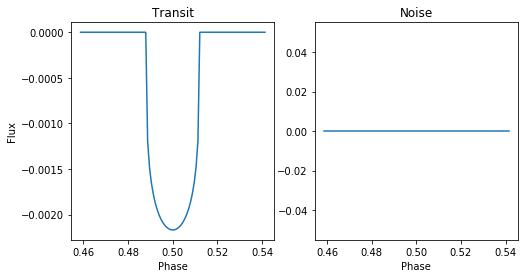

In [102]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(phase[index], transits[30])
ax[0].set_xlabel('Phase')
ax[0].set_ylabel('Flux')
ax[0].set_title('Transit')
ax[1].plot(phase[index], noise[30])
ax[1].set_xlabel('Phase')
ax[1].set_title('Noise')

In [94]:
#create output array
y = np.zeros(len(results_transit) + len(results_noise))
y[0:len(results_noise)] = int(0)
y[len(results_noise):len(y)] = int(1)
y = y.astype(int)

In [95]:
x = np.concatenate((noise,transits))

In [96]:
#Shuffle x and y arrays together
indices = np.arange(x.shape[0])
np.random.shuffle(indices)

x = x[indices]
y = y[indices]

In [97]:
#split up training and validation sets
x_train = x[0:int(.8*len(x))]
y_train = y[0:int(.8*len(y))]
x_test = x[int(.8*len(x)): len(x)]
y_test = y[int(.8*len(y)): len(y)]

In [98]:
# Network I was orginally trying
"""x = Input(shape = (width,1))#x_train.shape[1:])
h = Conv1D(32, 2, activation = 'relu')(x)
h = AveragePooling1D(2)(h)
h = Conv1D(64, 6,  activation = 'relu')(h)
h = Conv1D(64, 7,  activation = 'relu')(h)
h = AveragePooling1D(2)(h)
h = Flatten()(h)
h = Dense(16, activation = 'relu')(h)
y = Dense(1, activation = 'sigmoid')(h)
"""

from tensorflow.keras import metrics

#Network found 
def make_cnn(maxlen):

    pool_length = 3

    model = Sequential()
    model.add(Conv1D(kernel_size=5, filters=8,
                            activation=PRELU(),
                            input_shape=(maxlen,1),
                            #strides=1, # same as subsample_length?
                            name='conv1',
                            padding="valid"))
    model.add(AveragePooling1D(pool_size=pool_length))


    model.add(Conv1D(kernel_size=5, filters=8,
                            activation=PRELU(),
                            input_shape=(maxlen,1),
                            #strides=1, # same as subsample_length?
                            name='conv2',
                            padding="valid"))
    model.add(AveragePooling1D(pool_size=pool_length))

    # conv2
    #model.add(Convolution1D(nb_filter=4,
    #                        filter_length=filter_length,
    #                        border_mode='valid',
    #                        activation='linear',
    #                        subsample_length=1,
    #                        name='conv2'))
    #model.add(AveragePooling1D(pool_length=pool_length))
    model.add(Flatten())

    model.add(Dense(64, kernel_initializer='he_normal',bias_initializer='zeros'))
    model.add(PRELU())
    #model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32, kernel_initializer='he_normal',bias_initializer='zeros'))
    model.add(PRELU())
    #model.add(Activation('relu'))

    model.add(Dense(8, kernel_initializer='he_normal',bias_initializer='zeros'))
    model.add(PRELU())
    #model.add(Activation('relu'))

    model.add(Dense(1))

    model.add(Activation('sigmoid'))

    model.summary()
    SGDsolver = SGD(lr=0.1, momentum=0.25, decay=0.0001, nesterov=True)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [metrics.Accuracy(name='acc')])
    
    return model

In [99]:
model = make_cnn(width)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 96, 8)             816       
_________________________________________________________________
average_pooling1d_16 (Averag (None, 32, 8)             0         
_________________________________________________________________
conv2 (Conv1D)               (None, 28, 8)             552       
_________________________________________________________________
average_pooling1d_17 (Averag (None, 9, 8)              0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4672      
_________________________________________________________________
p_re_lu_42 (PReLU)           (None, 64)               

In [100]:
history = model.fit(x=x_train, y=y_train,
          validation_data=(x_test, y_test),
          batch_size=16,
          epochs=1000,
          callbacks=[])

Epoch 1/1000
300/300 [==============================] - 3s 9ms/step - loss: 0.6932 - acc: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.0000e+00
Epoch 2/1000
300/300 [==============================] - 3s 11ms/step - loss: 0.6933 - acc: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.0000e+00
Epoch 3/1000
300/300 [==============================] - 3s 9ms/step - loss: 0.6932 - acc: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.0000e+00
Epoch 4/1000
300/300 [==============================] - 3s 11ms/step - loss: 0.6932 - acc: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.0000e+00
Epoch 5/1000
300/300 [==============================] - 3s 10ms/step - loss: 0.6932 - acc: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.0000e+00
Epoch 6/1000
300/300 [==============================] - 4s 13ms/step - loss: 0.6932 - acc: 0.0000e+00 - val_loss: 0.6932 - val_acc: 0.0000e+00
Epoch 7/1000
300/300 [==============================] - 4s 12ms/step - loss: 0.6932 - acc: 0.0000e+00 - val_loss: 0.6932 - val_acc: 0.0000e+00
E

Epoch 58/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.4427e-07 - acc: 0.4596 - val_loss: 8.4912e-09 - val_acc: 0.5000
Epoch 59/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.3045e-07 - acc: 0.4600 - val_loss: 7.1639e-09 - val_acc: 0.5008
Epoch 60/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.1475e-07 - acc: 0.4733 - val_loss: 5.6453e-09 - val_acc: 0.5008
Epoch 61/1000
300/300 [==============================] - 4s 14ms/step - loss: 1.0905e-07 - acc: 0.4721 - val_loss: 5.0190e-09 - val_acc: 0.5008
Epoch 62/1000
300/300 [==============================] - 4s 13ms/step - loss: 5.6225e-08 - acc: 0.4815 - val_loss: 4.1452e-09 - val_acc: 0.5008
Epoch 63/1000
300/300 [==============================] - 4s 13ms/step - loss: 7.9991e-08 - acc: 0.4794 - val_loss: 3.1906e-09 - val_acc: 0.5008
Epoch 64/1000
300/300 [==============================] - 4s 13ms/step - loss: 6.7630e-08 - acc: 0.4775 - val_loss: 2.7610e-09 - val_acc:

Epoch 115/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.4124e-10 - acc: 0.4998 - val_loss: 1.3237e-12 - val_acc: 0.5008
Epoch 116/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.1063e-10 - acc: 0.4998 - val_loss: 1.2644e-12 - val_acc: 0.5008
Epoch 117/1000
300/300 [==============================] - 4s 13ms/step - loss: 2.1773e-10 - acc: 0.4996 - val_loss: 1.3840e-12 - val_acc: 0.5008
Epoch 118/1000
300/300 [==============================] - 3s 11ms/step - loss: 1.4311e-10 - acc: 0.4998 - val_loss: 1.1218e-12 - val_acc: 0.5008
Epoch 119/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.1116e-10 - acc: 0.4996 - val_loss: 9.1217e-13 - val_acc: 0.5008
Epoch 120/1000
300/300 [==============================] - 4s 13ms/step - loss: 5.3842e-11 - acc: 0.4998 - val_loss: 8.0634e-13 - val_acc: 0.5008
Epoch 121/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.0312e-10 - acc: 0.4998 - val_loss: 6.2364e-13 - v

300/300 [==============================] - 3s 11ms/step - loss: 7.3131e-13 - acc: 0.4998 - val_loss: 2.7072e-16 - val_acc: 0.5008
Epoch 172/1000
300/300 [==============================] - 3s 10ms/step - loss: 5.6785e-13 - acc: 0.4998 - val_loss: 2.7010e-16 - val_acc: 0.5008
Epoch 173/1000
300/300 [==============================] - 3s 10ms/step - loss: 4.6005e-13 - acc: 0.4998 - val_loss: 2.6880e-16 - val_acc: 0.5008
Epoch 174/1000
300/300 [==============================] - 3s 10ms/step - loss: 7.7265e-13 - acc: 0.4998 - val_loss: 2.6830e-16 - val_acc: 0.5008
Epoch 175/1000
300/300 [==============================] - 3s 10ms/step - loss: 1.4860e-12 - acc: 0.4998 - val_loss: 2.6266e-16 - val_acc: 0.5008
Epoch 176/1000
300/300 [==============================] - 3s 10ms/step - loss: 2.2878e-12 - acc: 0.4998 - val_loss: 2.5815e-16 - val_acc: 0.5008
Epoch 177/1000
300/300 [==============================] - 2s 8ms/step - loss: 4.6277e-12 - acc: 0.4998 - val_loss: 2.4059e-16 - val_acc: 0.5008
E

Epoch 228/1000
300/300 [==============================] - 3s 9ms/step - loss: 7.1432e-13 - acc: 0.4998 - val_loss: 9.6759e-16 - val_acc: 0.5008
Epoch 229/1000
300/300 [==============================] - 3s 10ms/step - loss: 1.8174e-13 - acc: 0.4998 - val_loss: 9.6194e-16 - val_acc: 0.5008
Epoch 230/1000
300/300 [==============================] - 3s 9ms/step - loss: 6.9726e-13 - acc: 0.4998 - val_loss: 9.5627e-16 - val_acc: 0.5008
Epoch 231/1000
300/300 [==============================] - 3s 10ms/step - loss: 1.7081e-12 - acc: 0.4998 - val_loss: 9.5276e-16 - val_acc: 0.5008
Epoch 232/1000
300/300 [==============================] - 2s 8ms/step - loss: 1.1056e-12 - acc: 0.4998 - val_loss: 9.3688e-16 - val_acc: 0.5008
Epoch 233/1000
300/300 [==============================] - 3s 9ms/step - loss: 2.3559e-12 - acc: 0.4998 - val_loss: 8.7469e-16 - val_acc: 0.5008
Epoch 234/1000
300/300 [==============================] - 2s 7ms/step - loss: 2.0133e-13 - acc: 0.4998 - val_loss: 8.7087e-16 - val_ac

Epoch 285/1000
300/300 [==============================] - 4s 13ms/step - loss: 2.7282e-13 - acc: 0.4998 - val_loss: 3.8151e-16 - val_acc: 0.5008
Epoch 286/1000
300/300 [==============================] - 4s 13ms/step - loss: 2.9841e-13 - acc: 0.4998 - val_loss: 3.8103e-16 - val_acc: 0.5008
Epoch 287/1000
300/300 [==============================] - 4s 14ms/step - loss: 1.7855e-13 - acc: 0.4998 - val_loss: 3.7900e-16 - val_acc: 0.5008
Epoch 288/1000
300/300 [==============================] - 4s 13ms/step - loss: 4.3975e-11 - acc: 0.4998 - val_loss: 2.6023e-15 - val_acc: 0.5008
Epoch 289/1000
300/300 [==============================] - 2s 8ms/step - loss: 2.4774e-13 - acc: 0.4998 - val_loss: 2.5912e-15 - val_acc: 0.5008
Epoch 290/1000
300/300 [==============================] - 4s 13ms/step - loss: 2.5530e-12 - acc: 0.4998 - val_loss: 2.5372e-15 - val_acc: 0.5008
Epoch 291/1000
300/300 [==============================] - 3s 10ms/step - loss: 8.3658e-13 - acc: 0.4998 - val_loss: 2.4771e-15 - va

300/300 [==============================] - 4s 13ms/step - loss: 4.1682e-08 - acc: 0.4996 - val_loss: 9.6054e-16 - val_acc: 0.5008
Epoch 342/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.8680e-10 - acc: 0.4992 - val_loss: 8.3099e-16 - val_acc: 0.5008
Epoch 343/1000
300/300 [==============================] - 4s 12ms/step - loss: 8.6670e-12 - acc: 0.4998 - val_loss: 8.3141e-16 - val_acc: 0.5008
Epoch 344/1000
300/300 [==============================] - 2s 7ms/step - loss: 4.1575e-12 - acc: 0.4998 - val_loss: 8.3261e-16 - val_acc: 0.5008
Epoch 345/1000
300/300 [==============================] - 2s 8ms/step - loss: 1.3698e-09 - acc: 0.4996 - val_loss: 1.9731e-16 - val_acc: 0.5008
Epoch 346/1000
300/300 [==============================] - 4s 12ms/step - loss: 1.8218e-12 - acc: 0.4998 - val_loss: 1.9731e-16 - val_acc: 0.5008
Epoch 347/1000
300/300 [==============================] - 2s 7ms/step - loss: 2.2620e-09 - acc: 0.4996 - val_loss: 1.1554e-17 - val_acc: 0.5008
Epo

300/300 [==============================] - 3s 9ms/step - loss: 4.9356e-13 - acc: 0.4998 - val_loss: 9.8470e-19 - val_acc: 0.5008
Epoch 398/1000
300/300 [==============================] - 2s 8ms/step - loss: 1.5366e-12 - acc: 0.4998 - val_loss: 9.9009e-19 - val_acc: 0.5008
Epoch 399/1000
300/300 [==============================] - 3s 10ms/step - loss: 1.4561e-11 - acc: 0.4998 - val_loss: 9.2690e-19 - val_acc: 0.5008
Epoch 400/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.2351e-11 - acc: 0.4998 - val_loss: 1.3371e-18 - val_acc: 0.5008
Epoch 401/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.0120e-04 - acc: 0.4990 - val_loss: 2.2147e-13 - val_acc: 0.5008
Epoch 402/1000
300/300 [==============================] - 3s 11ms/step - loss: 2.3263e-05 - acc: 0.4925 - val_loss: 2.2314e-12 - val_acc: 0.5008
Epoch 403/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.2485e-10 - acc: 0.4998 - val_loss: 1.7946e-12 - val_acc: 0.5008
Ep

Epoch 454/1000
300/300 [==============================] - 3s 9ms/step - loss: 8.6970e-10 - acc: 0.4996 - val_loss: 1.5456e-13 - val_acc: 0.5008
Epoch 455/1000
300/300 [==============================] - 2s 7ms/step - loss: 3.4182e-10 - acc: 0.4998 - val_loss: 7.7868e-14 - val_acc: 0.5008
Epoch 456/1000
300/300 [==============================] - 3s 9ms/step - loss: 1.5029e-10 - acc: 0.4998 - val_loss: 6.4874e-14 - val_acc: 0.5008
Epoch 457/1000
300/300 [==============================] - 2s 7ms/step - loss: 5.7816e-11 - acc: 0.4998 - val_loss: 6.2027e-14 - val_acc: 0.5008
Epoch 458/1000
300/300 [==============================] - 3s 10ms/step - loss: 5.8699e-11 - acc: 0.4998 - val_loss: 5.8676e-14 - val_acc: 0.5008
Epoch 459/1000
300/300 [==============================] - 3s 10ms/step - loss: 3.7905e-11 - acc: 0.4998 - val_loss: 5.8155e-14 - val_acc: 0.5008
Epoch 460/1000
300/300 [==============================] - 3s 9ms/step - loss: 1.5437e-11 - acc: 0.4998 - val_loss: 5.8394e-14 - val_ac

300/300 [==============================] - 4s 13ms/step - loss: 3.8059e-13 - acc: 0.4998 - val_loss: 1.7882e-17 - val_acc: 0.5008
Epoch 511/1000
300/300 [==============================] - 4s 12ms/step - loss: 3.9765e-14 - acc: 0.4998 - val_loss: 1.7882e-17 - val_acc: 0.5008
Epoch 512/1000
300/300 [==============================] - 4s 14ms/step - loss: 6.2270e-15 - acc: 0.4998 - val_loss: 1.7882e-17 - val_acc: 0.5008
Epoch 513/1000
300/300 [==============================] - 3s 11ms/step - loss: 2.7801e-15 - acc: 0.4998 - val_loss: 1.7882e-17 - val_acc: 0.5008
Epoch 514/1000
300/300 [==============================] - 3s 11ms/step - loss: 1.0107e-13 - acc: 0.4998 - val_loss: 1.7882e-17 - val_acc: 0.5008
Epoch 515/1000
300/300 [==============================] - 3s 10ms/step - loss: 2.2294e-12 - acc: 0.4998 - val_loss: 1.7882e-17 - val_acc: 0.5008
Epoch 516/1000
300/300 [==============================] - 3s 12ms/step - loss: 3.6617e-15 - acc: 0.4998 - val_loss: 1.7882e-17 - val_acc: 0.5008


300/300 [==============================] - 3s 10ms/step - loss: 2.4792e-15 - acc: 0.4998 - val_loss: 2.9270e-18 - val_acc: 0.5008
Epoch 567/1000
300/300 [==============================] - 3s 11ms/step - loss: 1.0084e-14 - acc: 0.4998 - val_loss: 2.9297e-18 - val_acc: 0.5008
Epoch 568/1000
300/300 [==============================] - 4s 13ms/step - loss: 2.9097e-15 - acc: 0.4998 - val_loss: 2.9298e-18 - val_acc: 0.5008
Epoch 569/1000
300/300 [==============================] - 4s 14ms/step - loss: 2.8433e-15 - acc: 0.4998 - val_loss: 2.9298e-18 - val_acc: 0.5008
Epoch 570/1000
300/300 [==============================] - 4s 13ms/step - loss: 4.6518e-12 - acc: 0.4998 - val_loss: 2.9298e-18 - val_acc: 0.5008
Epoch 571/1000
300/300 [==============================] - 4s 13ms/step - loss: 4.7803e-15 - acc: 0.4998 - val_loss: 2.9301e-18 - val_acc: 0.5008
Epoch 572/1000
300/300 [==============================] - 4s 12ms/step - loss: 2.0564e-15 - acc: 0.4998 - val_loss: 2.9304e-18 - val_acc: 0.5008


300/300 [==============================] - 4s 12ms/step - loss: 3.0101e-13 - acc: 0.4998 - val_loss: 3.0263e-18 - val_acc: 0.5008
Epoch 623/1000
300/300 [==============================] - 2s 7ms/step - loss: 6.6455e-14 - acc: 0.4998 - val_loss: 2.9908e-18 - val_acc: 0.5008
Epoch 624/1000
300/300 [==============================] - 4s 12ms/step - loss: 9.2667e-14 - acc: 0.4998 - val_loss: 2.9501e-18 - val_acc: 0.5008
Epoch 625/1000
300/300 [==============================] - 4s 12ms/step - loss: 5.6960e-13 - acc: 0.4998 - val_loss: 2.6732e-18 - val_acc: 0.5008
Epoch 626/1000
300/300 [==============================] - 3s 11ms/step - loss: 3.8800e-14 - acc: 0.4998 - val_loss: 2.6551e-18 - val_acc: 0.5008
Epoch 627/1000
300/300 [==============================] - 4s 12ms/step - loss: 1.0637e-13 - acc: 0.4998 - val_loss: 2.6069e-18 - val_acc: 0.5008
Epoch 628/1000
300/300 [==============================] - 2s 7ms/step - loss: 1.3377e-13 - acc: 0.4998 - val_loss: 2.5364e-18 - val_acc: 0.5008
Ep

300/300 [==============================] - 2s 8ms/step - loss: 1.4660e-14 - acc: 0.4998 - val_loss: 1.4933e-18 - val_acc: 0.5008
Epoch 679/1000
300/300 [==============================] - 4s 14ms/step - loss: 2.0570e-14 - acc: 0.4998 - val_loss: 1.4844e-18 - val_acc: 0.5008
Epoch 680/1000
300/300 [==============================] - 3s 9ms/step - loss: 7.3792e-14 - acc: 0.4998 - val_loss: 1.4591e-18 - val_acc: 0.5008
Epoch 681/1000
300/300 [==============================] - 3s 11ms/step - loss: 9.2952e-15 - acc: 0.4998 - val_loss: 1.4555e-18 - val_acc: 0.5008
Epoch 682/1000
300/300 [==============================] - 3s 12ms/step - loss: 1.0211e-14 - acc: 0.4998 - val_loss: 1.4520e-18 - val_acc: 0.5008
Epoch 683/1000
300/300 [==============================] - 3s 11ms/step - loss: 1.1101e-14 - acc: 0.4998 - val_loss: 1.4490e-18 - val_acc: 0.5008
Epoch 684/1000
300/300 [==============================] - 4s 13ms/step - loss: 7.3909e-15 - acc: 0.4998 - val_loss: 1.4461e-18 - val_acc: 0.5008
Ep

300/300 [==============================] - 4s 13ms/step - loss: 7.8256e-15 - acc: 0.4998 - val_loss: 9.1240e-19 - val_acc: 0.5008
Epoch 735/1000
300/300 [==============================] - 4s 12ms/step - loss: 5.3951e-15 - acc: 0.4998 - val_loss: 9.1158e-19 - val_acc: 0.5008
Epoch 736/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.1261e-14 - acc: 0.4998 - val_loss: 9.1018e-19 - val_acc: 0.5008
Epoch 737/1000
300/300 [==============================] - 3s 11ms/step - loss: 3.5895e-14 - acc: 0.4998 - val_loss: 9.0368e-19 - val_acc: 0.5008
Epoch 738/1000
300/300 [==============================] - 3s 9ms/step - loss: 3.0255e-14 - acc: 0.4998 - val_loss: 8.9821e-19 - val_acc: 0.5008
Epoch 739/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.5590e-14 - acc: 0.4998 - val_loss: 8.9578e-19 - val_acc: 0.5008
Epoch 740/1000
300/300 [==============================] - 4s 12ms/step - loss: 5.5046e-14 - acc: 0.4998 - val_loss: 8.9049e-19 - val_acc: 0.5008
E

300/300 [==============================] - 3s 11ms/step - loss: 2.9219e-14 - acc: 0.4998 - val_loss: 6.9136e-19 - val_acc: 0.5008
Epoch 791/1000
300/300 [==============================] - 4s 14ms/step - loss: 1.2024e-13 - acc: 0.4998 - val_loss: 6.7771e-19 - val_acc: 0.5008
Epoch 792/1000
300/300 [==============================] - 3s 12ms/step - loss: 1.2745e-14 - acc: 0.4998 - val_loss: 6.7677e-19 - val_acc: 0.5008
Epoch 793/1000
300/300 [==============================] - 4s 13ms/step - loss: 2.4521e-14 - acc: 0.4998 - val_loss: 6.7495e-19 - val_acc: 0.5008
Epoch 794/1000
300/300 [==============================] - 4s 13ms/step - loss: 5.3523e-14 - acc: 0.4998 - val_loss: 6.7169e-19 - val_acc: 0.5008
Epoch 795/1000
300/300 [==============================] - 4s 14ms/step - loss: 8.0391e-15 - acc: 0.4998 - val_loss: 6.7108e-19 - val_acc: 0.5008
Epoch 796/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.6125e-13 - acc: 0.4998 - val_loss: 6.6498e-19 - val_acc: 0.5008


300/300 [==============================] - 4s 13ms/step - loss: 3.1698e-14 - acc: 0.4998 - val_loss: 5.9382e-19 - val_acc: 0.5008
Epoch 847/1000
300/300 [==============================] - 4s 13ms/step - loss: 7.3697e-15 - acc: 0.4998 - val_loss: 5.9344e-19 - val_acc: 0.5008
Epoch 848/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.4650e-14 - acc: 0.4998 - val_loss: 5.9292e-19 - val_acc: 0.5008
Epoch 849/1000
300/300 [==============================] - 4s 13ms/step - loss: 8.4189e-15 - acc: 0.4998 - val_loss: 5.9253e-19 - val_acc: 0.5008
Epoch 850/1000
300/300 [==============================] - 4s 13ms/step - loss: 4.6661e-15 - acc: 0.4998 - val_loss: 5.9234e-19 - val_acc: 0.5008
Epoch 851/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.2702e-14 - acc: 0.4998 - val_loss: 5.9169e-19 - val_acc: 0.5008
Epoch 852/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.3940e-13 - acc: 0.4998 - val_loss: 5.8640e-19 - val_acc: 0.5008


300/300 [==============================] - 4s 12ms/step - loss: 4.7806e-15 - acc: 0.4998 - val_loss: 5.1455e-19 - val_acc: 0.5008
Epoch 903/1000
300/300 [==============================] - 4s 12ms/step - loss: 2.4886e-14 - acc: 0.4998 - val_loss: 5.1445e-19 - val_acc: 0.5008
Epoch 904/1000
300/300 [==============================] - 3s 11ms/step - loss: 4.7998e-15 - acc: 0.4998 - val_loss: 5.1442e-19 - val_acc: 0.5008
Epoch 905/1000
300/300 [==============================] - 4s 14ms/step - loss: 1.8831e-15 - acc: 0.4998 - val_loss: 5.1441e-19 - val_acc: 0.5008
Epoch 906/1000
300/300 [==============================] - 4s 13ms/step - loss: 1.3213e-14 - acc: 0.4998 - val_loss: 5.1435e-19 - val_acc: 0.5008
Epoch 907/1000
300/300 [==============================] - 3s 10ms/step - loss: 4.3038e-15 - acc: 0.4998 - val_loss: 5.1432e-19 - val_acc: 0.5008
Epoch 908/1000
300/300 [==============================] - 4s 13ms/step - loss: 3.0216e-15 - acc: 0.4998 - val_loss: 5.1431e-19 - val_acc: 0.5008


300/300 [==============================] - 4s 12ms/step - loss: 3.4782e-15 - acc: 0.4998 - val_loss: 5.6552e-19 - val_acc: 0.5008
Epoch 959/1000
300/300 [==============================] - 4s 13ms/step - loss: 5.5259e-14 - acc: 0.4998 - val_loss: 5.6734e-19 - val_acc: 0.5008
Epoch 960/1000
300/300 [==============================] - 4s 13ms/step - loss: 8.9965e-15 - acc: 0.4998 - val_loss: 5.6785e-19 - val_acc: 0.5008
Epoch 961/1000
300/300 [==============================] - 3s 9ms/step - loss: 9.5578e-16 - acc: 0.4998 - val_loss: 5.6785e-19 - val_acc: 0.5008
Epoch 962/1000
300/300 [==============================] - 4s 13ms/step - loss: 3.9342e-15 - acc: 0.4998 - val_loss: 5.6794e-19 - val_acc: 0.5008
Epoch 963/1000
300/300 [==============================] - 4s 12ms/step - loss: 4.2502e-12 - acc: 0.4998 - val_loss: 8.0042e-19 - val_acc: 0.5008
Epoch 964/1000
300/300 [==============================] - 4s 12ms/step - loss: 7.8424e-16 - acc: 0.4998 - val_loss: 8.0177e-19 - val_acc: 0.5008
E

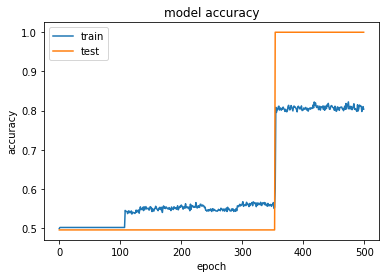

In [81]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

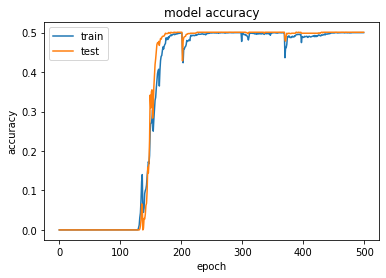

In [71]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(y_test[0])
x_test[0]

In [ ]:
x_train.shape[1:]

In [ ]:
x_train[5]